# CSV to NetCDF Conversion Pipeline

This notebook demonstrates a scalable approach for converting large CSV files containing ensemble climate data to NetCDF format using Dask and Xarray.

## Overview
The process involves:
1. **Data Loading**: Reading large CSV files efficiently with Dask
2. **Data Reshaping**: Converting wide-format ensemble data to long format
3. **Intermediate Storage**: Saving to Parquet format for optimization
4. **Format Conversion**: Converting to Xarray Dataset and NetCDF format
5. **Verification**: Loading and inspecting the final NetCDF file

## Dataset Description
- **Input**: SSP245_PRECT.csv - Climate precipitation data with ensemble members
- **Structure**: Time series data with coordinates (time, lat, lon) and multiple ensemble members (tp_001, tp_002, etc.)
- **Output**: NetCDF file with 4D structure (time, lat, lon, ensemble)

## Step 1: Install Required Dependencies

Installing the necessary packages for handling large datasets:
- **dask[dataframe]**: For out-of-core parallel processing of large datasets
- **xarray**: For working with labeled multi-dimensional arrays (NetCDF)
- **zarr**: For chunked, compressed array storage
- **fastparquet**: Fast Parquet file I/O for Python

In [1]:
!pip install dask[dataframe] xarray zarr fastparquet

## Step 2: Import Libraries

Importing the core libraries needed for data processing:
- **pandas**: For data manipulation and analysis
- **re**: For regular expression pattern matching (to identify ensemble columns)
- **dask.dataframe**: For lazy evaluation and parallel processing of large datasets
- **xarray**: For working with labeled multi-dimensional data and NetCDF files

In [18]:
import pandas as pd
import re
import dask.dataframe as dd
import xarray as xr

## Step 3: Load Large CSV Data with Dask

Loading the climate data CSV file efficiently:
- **File**: `SSP245_PRECT.csv` contains precipitation data from climate ensemble runs
- **Chunking**: Using 256MB blocks to manage memory usage
- **Date Parsing**: Automatically parsing the 'time' column as datetime
- **Missing Values**: Handling missing data appropriately with `assume_missing=True`

This approach allows processing files larger than available RAM by loading data in chunks.

In [20]:
ddf = dd.read_csv(
    "data/SSP245_PRECT.csv",
    parse_dates=["time"],
    blocksize="256MB",   # each chunk ~256MB, tune for your RAM
    assume_missing=True
)

In [21]:
ddf

,Unnamed: 0,time,lat,lon,tp_001,tp_002,tp_003,tp_004,tp_005,tp_006,tp_007,tp_008,tp_009,tp_010,tp_truth
npartitions=4,,,,,,,,,,,,,,,
,float64,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Step 4: Inspect the Loaded Data

Examining the structure of the loaded dataset to understand:
- **Dimensions**: Number of rows and columns
- **Column Names**: Coordinate variables (time, lat, lon) and ensemble members (tp_001, tp_002, etc.)
- **Data Types**: Ensuring proper data types for efficient processing
- **Memory Usage**: Understanding the computational requirements

In [23]:
# ----------------------------
# 2. Find ensemble member cols
# ----------------------------
value_cols = [c for c in ddf.columns if re.fullmatch(r"tp_\d{3}", c)]

# ----------------------------
# 3. Reshape: wide → long
# ----------------------------
ddf_long = ddf.melt(
    id_vars=["time", "lat", "lon", "tp_truth"],
    value_vars=value_cols,
    var_name="member_name",
    value_name="tp"
)

# Extract ensemble index (tp_001 → 1, etc.)
ddf_long["ensemble"] = ddf_long["member_name"].str[3:].astype("int16")
ddf_long = ddf_long.drop(columns=["member_name"])

## Step 5: Reshape Data from Wide to Long Format

Converting the ensemble data structure for better organization:

### Process:
1. **Identify Ensemble Columns**: Use regex pattern `tp_\d{3}` to find columns like `tp_001`, `tp_002`, etc.
2. **Melt Operation**: Transform wide format (multiple ensemble columns) to long format (single ensemble dimension)
3. **Extract Ensemble Index**: Convert member names (`tp_001`) to numeric indices (1, 2, 3, ...)
4. **Optimize Data Types**: Use `int16` for ensemble indices to save memory

### Result:
- **Before**: Multiple columns (tp_001, tp_002, ..., tp_N)  
- **After**: Single 'tp' column with 'ensemble' dimension

In [24]:
# ----------------------------
# 4. Save intermediate as Parquet (efficient)
# ----------------------------
# This step streams the CSV into a columnar, compressed format
ddf_long.to_parquet(
    "precip_parquet",
    engine="pyarrow",
    compression="snappy",
    write_index=False
)

## Step 6: Save Intermediate Data as Parquet

Creating an efficient intermediate storage format:

### Why Parquet?
- **Columnar Storage**: Optimized for analytical queries and compression
- **Compression**: Snappy compression reduces file size significantly
- **Performance**: Much faster read/write compared to CSV
- **Schema Preservation**: Maintains data types and structure

### Configuration:
- **Engine**: PyArrow for high performance
- **Compression**: Snappy for good compression with fast decompression
- **Partitioning**: Automatic partitioning for large datasets

In [26]:
# ----------------------------
# 5. Load Parquet into Xarray
# ----------------------------
ddf_parquet = dd.read_parquet("precip_parquet")
ds = xr.Dataset.from_dataframe(ddf_parquet)

## Step 7: Convert to Xarray Dataset

Loading the Parquet data and converting to Xarray format:

### Benefits of Xarray:
- **Labeled Dimensions**: Named coordinates (time, lat, lon, ensemble)
- **Metadata Support**: Can store attributes, units, and descriptions
- **NetCDF Integration**: Native support for NetCDF format
- **Broadcasting**: Automatic alignment of dimensions for operations

### Process:
1. **Load Parquet**: Read the optimized intermediate format
2. **Create Dataset**: Convert Dask DataFrame to Xarray Dataset
3. **Preserve Structure**: Maintain all coordinate information

In [27]:
# ----------------------------
# 6. Reshape into dimensions
# ----------------------------
# Now ds still has 'time','lat','lon','ensemble' as coords
# If needed, unstack to 4D tensor: (time, ensemble, lat, lon)

ds = ds.set_index(index=["time","lat","lon","ensemble"])
ds = ds.unstack("index")   # creates (time, lat, lon, ensemble) dims

## Step 8: Reshape to 4D Structure

Organizing the data into a proper multi-dimensional array:

### Current Structure:
- **Format**: Long format with row-based coordinates
- **Index**: Multi-index with (time, lat, lon, ensemble)

### Target Structure:
- **Format**: 4D tensor with named dimensions
- **Dimensions**: `(time, lat, lon, ensemble)`
- **Shape**: Proper grid structure for climate data analysis

### Operations:
1. **Set Multi-Index**: Define coordinate hierarchy
2. **Unstack**: Convert from long format to multi-dimensional grid
3. **Result**: 4D array suitable for climate analysis and visualization

In [28]:
# ----------------------------
# 7. Save to NetCDF (streaming)
# ----------------------------
comp = dict(zlib=True, complevel=4, dtype="float32")
encoding = {var: comp for var in ds.data_vars}

ds.to_netcdf(
    "precip.nc",
    encoding=encoding,
    compute=True   # Dask streams chunks → NetCDF
)

## Step 9: Export to NetCDF Format

Creating the final NetCDF file with optimized settings:

### Compression Configuration:
- **Algorithm**: zlib compression (widely supported)
- **Level**: Compression level 4 (balance between size and speed)
- **Data Type**: float32 (sufficient precision, reduced file size)

### NetCDF Benefits:
- **Self-Describing**: Contains metadata about variables and dimensions
- **Platform Independent**: Works across different operating systems
- **Climate Standard**: Widely used in atmospheric and oceanographic sciences
- **Tool Support**: Compatible with NCO, CDO, and visualization tools

### Streaming Process:
- **Compute=True**: Forces immediate computation and writing
- **Chunked Processing**: Dask processes data in chunks to manage memory
- **Efficient I/O**: Optimized for large dataset export

In [29]:
ds = xr.open_dataset("precip.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 600MB
Dimensions:   (time: 3809, lat: 48, lon: 41, ensemble: 10)
Coordinates:
  * time      (time) datetime64[ns] 30kB 2015-01-01 2015-01-02 ... 2025-06-08
  * lat       (lat) float64 384B -14.61 -13.66 -12.72 ... 27.8 28.74 29.69
  * lon       (lon) float64 328B 90.0 91.25 92.5 93.75 ... 137.5 138.8 140.0
  * ensemble  (ensemble) int16 20B 1 2 3 4 5 6 7 8 9 10
Data variables:
    tp_truth  (time, lat, lon, ensemble) float32 300MB ...
    tp        (time, lat, lon, ensemble) float32 300MB ...

## Summary and Performance Notes

### Pipeline Overview:
This notebook demonstrates an efficient pipeline for converting large climate ensemble CSV data to NetCDF format:

**CSV → Dask DataFrame → Parquet → Xarray Dataset → NetCDF**

### Key Performance Benefits:
1. **Memory Efficiency**: Dask enables processing datasets larger than RAM
2. **Intermediate Optimization**: Parquet format provides fast I/O and compression
3. **Parallel Processing**: Chunked operations leverage multiple CPU cores
4. **Compressed Output**: NetCDF with zlib compression reduces storage requirements

### Scalability:
- **Large Files**: Can handle multi-GB CSV files efficiently
- **Memory Management**: Configurable chunk sizes prevent memory overflow
- **Parallel I/O**: Streaming operations minimize memory footprint
- **Format Optimization**: NetCDF provides better read performance than CSV

### Next Steps:
- Add metadata attributes to the NetCDF file (units, descriptions, etc.)
- Implement data validation checks
- Consider chunking strategies for different analysis patterns
- Add error handling for robust production use

## Step 10: Verify the Final NetCDF File

Loading and inspecting the created NetCDF file to ensure successful conversion:

### Verification Checks:
- **File Integrity**: Confirm the file opens without errors
- **Dimensions**: Verify correct shape (time, lat, lon, ensemble)
- **Variables**: Check that all data variables are present
- **Metadata**: Inspect coordinate information and attributes
- **Data Types**: Confirm proper encoding and compression

### Expected Output:
- **Dataset Structure**: 4D precipitation data with proper coordinates
- **Variables**: `tp` (precipitation) and `tp_truth` (reference data)
- **Coordinates**: `time`, `latitude`, `longitude`, `ensemble`
- **Attributes**: Metadata describing the dataset origin and processing

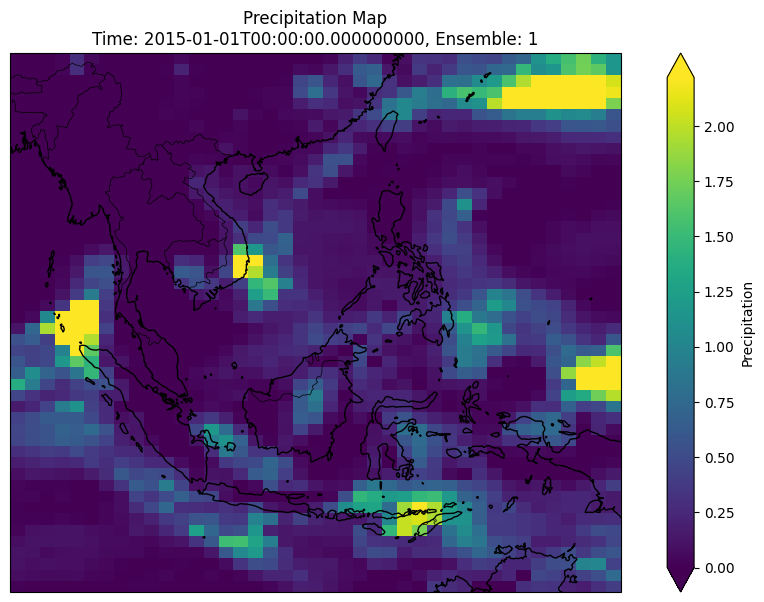

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Select a time and ensemble member to plot
time_idx = 0  # first time step
ensemble_idx = 0  # first ensemble member

# Extract data for plotting
tp_map = ds.tp.isel(time=time_idx, ensemble=ensemble_idx)

plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
tp_map.plot(
    ax=ax,
    x='lon',
    y='lat',
    cmap='viridis',
    robust=True,
    cbar_kwargs={'label': 'Precipitation'},
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title(f"Precipitation Map\nTime: {str(ds.time.values[time_idx])}, Ensemble: {ds.ensemble.values[ensemble_idx]}")
plt.show()